# Фреймворк PyTorch для разработки искусственных нейронных сетей

## Урок 4. CNN Свертки

1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import torch
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

import warnings
warnings.filterwarnings('ignore')

In [2]:
!mkdir models

Џ®¤Ї ЇЄ  Ё«Ё д ©« models г¦Ґ бгйҐбвўгҐв.


In [3]:
batch_size = 64
learning_rate = 3e-3
num_epochs = 20

In [4]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]),
    'test':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
}

In [5]:
data_sets = {
    'train': torchvision.datasets.CIFAR100(root='data', train=True, download=True, transform=data_transforms['train']),
    'test': torchvision.datasets.CIFAR100(root='data', download=True, transform=data_transforms['test'])
}

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(data_sets['train'])
print('='*85)
print(data_sets['test'])

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


In [7]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(data_sets['train'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(data_sets['test'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0)
}

In [8]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cpu


In [9]:
def train_model(model):
    train_acces, test_acces = [], []
    train_losses, test_losses = [], []
    total_step = len(dataloaders['train'])
    test_loss_min = np.Inf
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}\n')

        network_learned = False

        for phase in ['train', 'test']:

            running_loss = 0.0
            running_corrects = 0

            if phase == 'train':
                model.train()

                for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):

                    if use_cuda:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)

                    inputs = inputs.float()
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
                    if (batch_idx) % 20 == 0:
                        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs-1, batch_idx, total_step, loss.item()))
                scheduler.step()
            else:
                with torch.no_grad():
                    model.eval()
                    for inputs, labels in dataloaders[phase]:
                        if use_cuda:
                            inputs = Variable(inputs.cuda())
                            labels = Variable(labels.cuda())
                        else:
                            inputs, labels = Variable(inputs), Variable(labels)

                        inputs = inputs.float()
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)
                        running_loss += loss.item()
                        running_corrects += torch.sum(preds == labels.data)
                network_learned = running_loss < test_loss_min
                test_loss_min = running_loss if network_learned else test_loss_min


            epoch_loss = running_loss / len(data_sets[phase])
            epoch_acc = running_corrects.double() / len(data_sets[phase])

            if phase == 'train':
                train_acces.append(epoch_acc * 100)
                train_losses.append(epoch_loss)
            else:
                test_acces.append(epoch_acc * 100)
                test_losses.append(epoch_loss)
        print(f'\ntrain-loss: {np.mean(train_losses):.4f}, train-acc: {train_acces[-1]:.4f}')
        print(f'test loss: {np.mean(test_losses):.4f}, test acc: {test_acces[-1]:.4f}\n')

        if network_learned:
            torch.save(model.state_dict(), 'models/weights.h5')
            print('Improvement-Detected, save-model')
            
    if use_cuda:
        train_acces = [_.cpu().item() for _ in train_acces]
        test_acces = [_.cpu().item() for _ in test_acces]
    return train_acces, test_acces, train_losses, test_losses

# CNN (самописная)

In [10]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        # self.fc2 = torch.nn.Linear(200, 60)
        # self.out = torch.nn.Linear(60, 10)
        self.out = torch.nn.Linear(200, 100)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dp_four(x)
        # x = self.fc2(x)
        # x = F.relu(x)
        return self.out(x)
    
model_my = Net()
model_my = model_my.cuda() if use_cuda else model_my

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_my.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [11]:
summary(model_my, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 200]          96,200
           Linear-10                  [-1, 100]          20,100
Total params: 198,746
Trainable params: 198,746
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.40
Params size (MB): 0.76
Estimated T

In [12]:
train_acces_my, test_acces_my, train_losses_my, test_losses_my = train_model(model_my)

Epoch 0

Epoch [0/19], Step [0/782], Loss: 4.6806
Epoch [0/19], Step [20/782], Loss: 4.5608
Epoch [0/19], Step [40/782], Loss: 4.5365
Epoch [0/19], Step [60/782], Loss: 4.4853
Epoch [0/19], Step [80/782], Loss: 4.3314
Epoch [0/19], Step [100/782], Loss: 4.3147
Epoch [0/19], Step [120/782], Loss: 4.4228
Epoch [0/19], Step [140/782], Loss: 4.3474
Epoch [0/19], Step [160/782], Loss: 4.2479
Epoch [0/19], Step [180/782], Loss: 4.2076
Epoch [0/19], Step [200/782], Loss: 4.2375
Epoch [0/19], Step [220/782], Loss: 3.9569
Epoch [0/19], Step [240/782], Loss: 3.9804
Epoch [0/19], Step [260/782], Loss: 3.9235
Epoch [0/19], Step [280/782], Loss: 4.1796
Epoch [0/19], Step [300/782], Loss: 3.9997
Epoch [0/19], Step [320/782], Loss: 4.0187
Epoch [0/19], Step [340/782], Loss: 3.6736
Epoch [0/19], Step [360/782], Loss: 3.7770
Epoch [0/19], Step [380/782], Loss: 3.9426
Epoch [0/19], Step [400/782], Loss: 3.6487
Epoch [0/19], Step [420/782], Loss: 3.7818
Epoch [0/19], Step [440/782], Loss: 3.5845
Epoch [0

In [13]:
model_my.eval()

Net(
  (dp_three): Dropout(p=0.2, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=100, bias=True)
)

# CNN: дообучение ResNet-50

In [14]:
model = models.resnet50(pretrained=True)

for param in list(model.parameters())[:]:
    param.requires_grad = False
    
model = model.cuda() if use_cuda else model
    
model.fc = nn.Linear(2048, 100)

model.fc = model.fc.cuda() if use_cuda else model.fc

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [15]:
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [16]:
train_acces, test_acces, train_losses, test_losses = train_model(model)

Epoch 0

Epoch [0/19], Step [0/782], Loss: 4.6914
Epoch [0/19], Step [20/782], Loss: 4.5299
Epoch [0/19], Step [40/782], Loss: 4.5017
Epoch [0/19], Step [60/782], Loss: 4.3493
Epoch [0/19], Step [80/782], Loss: 4.2941
Epoch [0/19], Step [100/782], Loss: 4.1697
Epoch [0/19], Step [120/782], Loss: 4.1873
Epoch [0/19], Step [140/782], Loss: 4.1601
Epoch [0/19], Step [160/782], Loss: 3.8075
Epoch [0/19], Step [180/782], Loss: 3.7827
Epoch [0/19], Step [200/782], Loss: 3.8904
Epoch [0/19], Step [220/782], Loss: 3.6194
Epoch [0/19], Step [240/782], Loss: 3.6801
Epoch [0/19], Step [260/782], Loss: 3.4809
Epoch [0/19], Step [280/782], Loss: 3.4899
Epoch [0/19], Step [300/782], Loss: 3.6931
Epoch [0/19], Step [320/782], Loss: 3.3627
Epoch [0/19], Step [340/782], Loss: 3.5818
Epoch [0/19], Step [360/782], Loss: 3.5639
Epoch [0/19], Step [380/782], Loss: 3.7114
Epoch [0/19], Step [400/782], Loss: 3.4633
Epoch [0/19], Step [420/782], Loss: 3.2832
Epoch [0/19], Step [440/782], Loss: 3.2933
Epoch [0

In [17]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

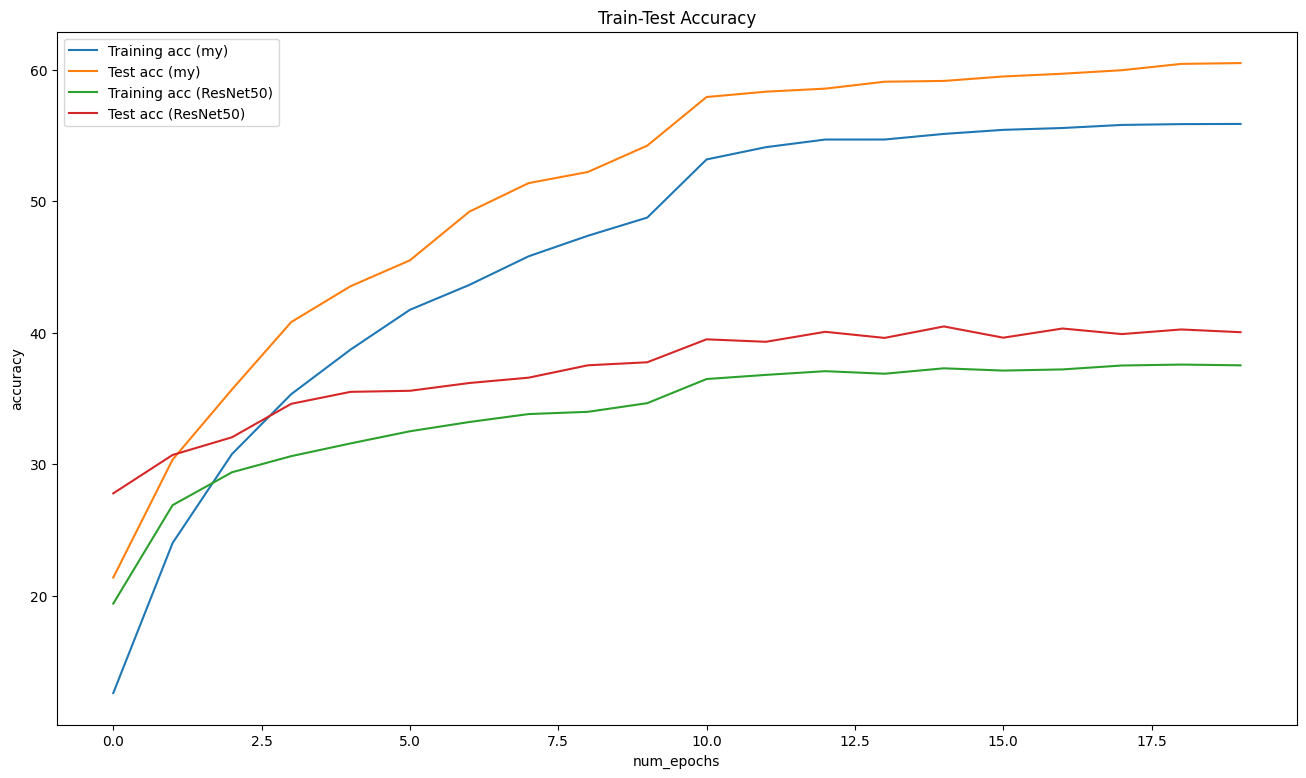

In [18]:
plt.figure(figsize=(16, 9))
plt.title("Train-Test Accuracy")
plt.plot(train_acces_my, label='Training acc (my)')
plt.plot(test_acces_my, label='Test acc (my)')
plt.plot(train_acces, label='Training acc (ResNet50)')
plt.plot(test_acces, label='Test acc (ResNet50)')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.legend();

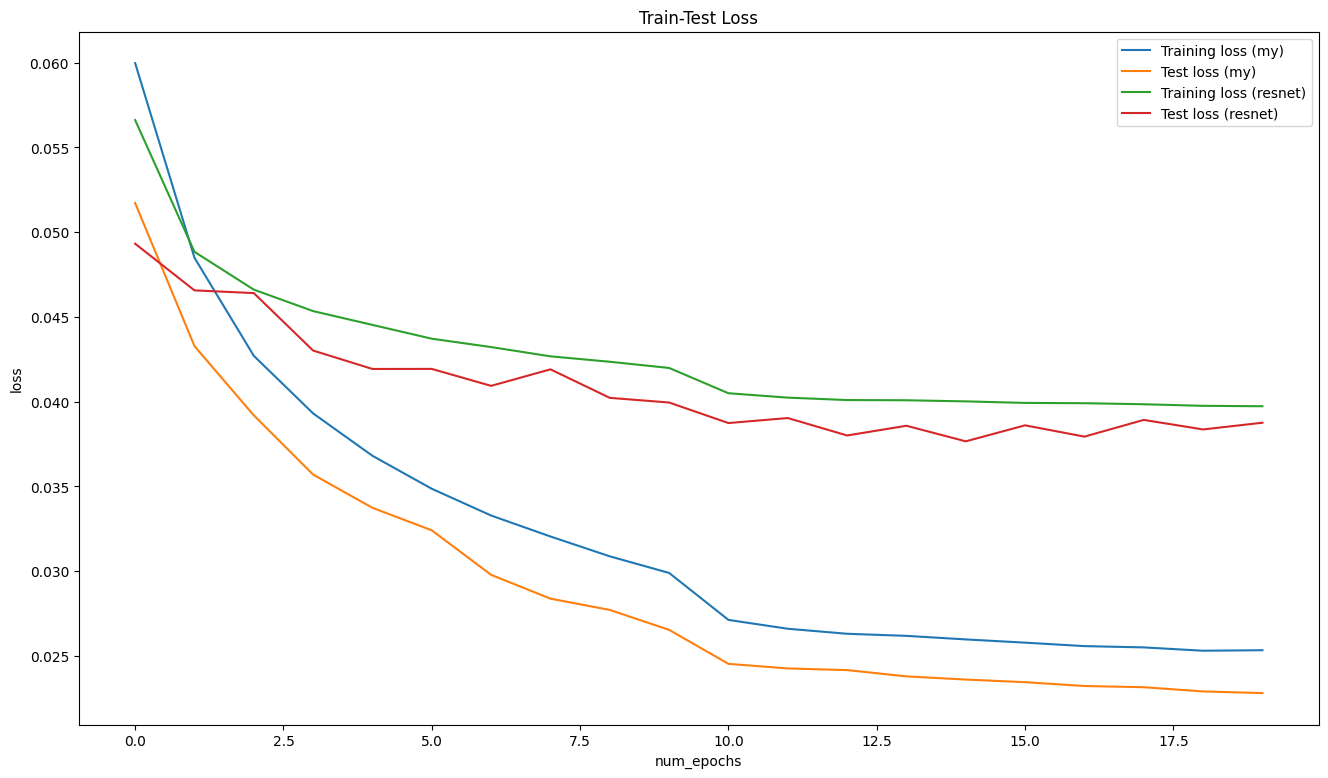

In [19]:
plt.figure(figsize=(16, 9))
plt.title("Train-Test Loss")
plt.plot(train_losses_my, label='Training loss (my)')
plt.plot(test_losses_my, label='Test loss (my)')
plt.plot(train_losses, label='Training loss (resnet)')
plt.plot(test_losses, label='Test loss (resnet)')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend();

In [20]:
num = 20
classes = data_sets['test'].classes
indices = list(range(len(data_sets['test'])))
np.random.shuffle(indices)
idx = indices[:num]
sampler = SubsetRandomSampler(idx)
loader = torch.utils.data.DataLoader(data_sets['test'], sampler=sampler, batch_size=num)
dataiter = iter(loader)
images, labels = next(dataiter)

In [21]:
def imshow(ax, inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    ax.imshow(inp)
    ax.axis("off")
    if title is not None:
        ax.set_title(title)

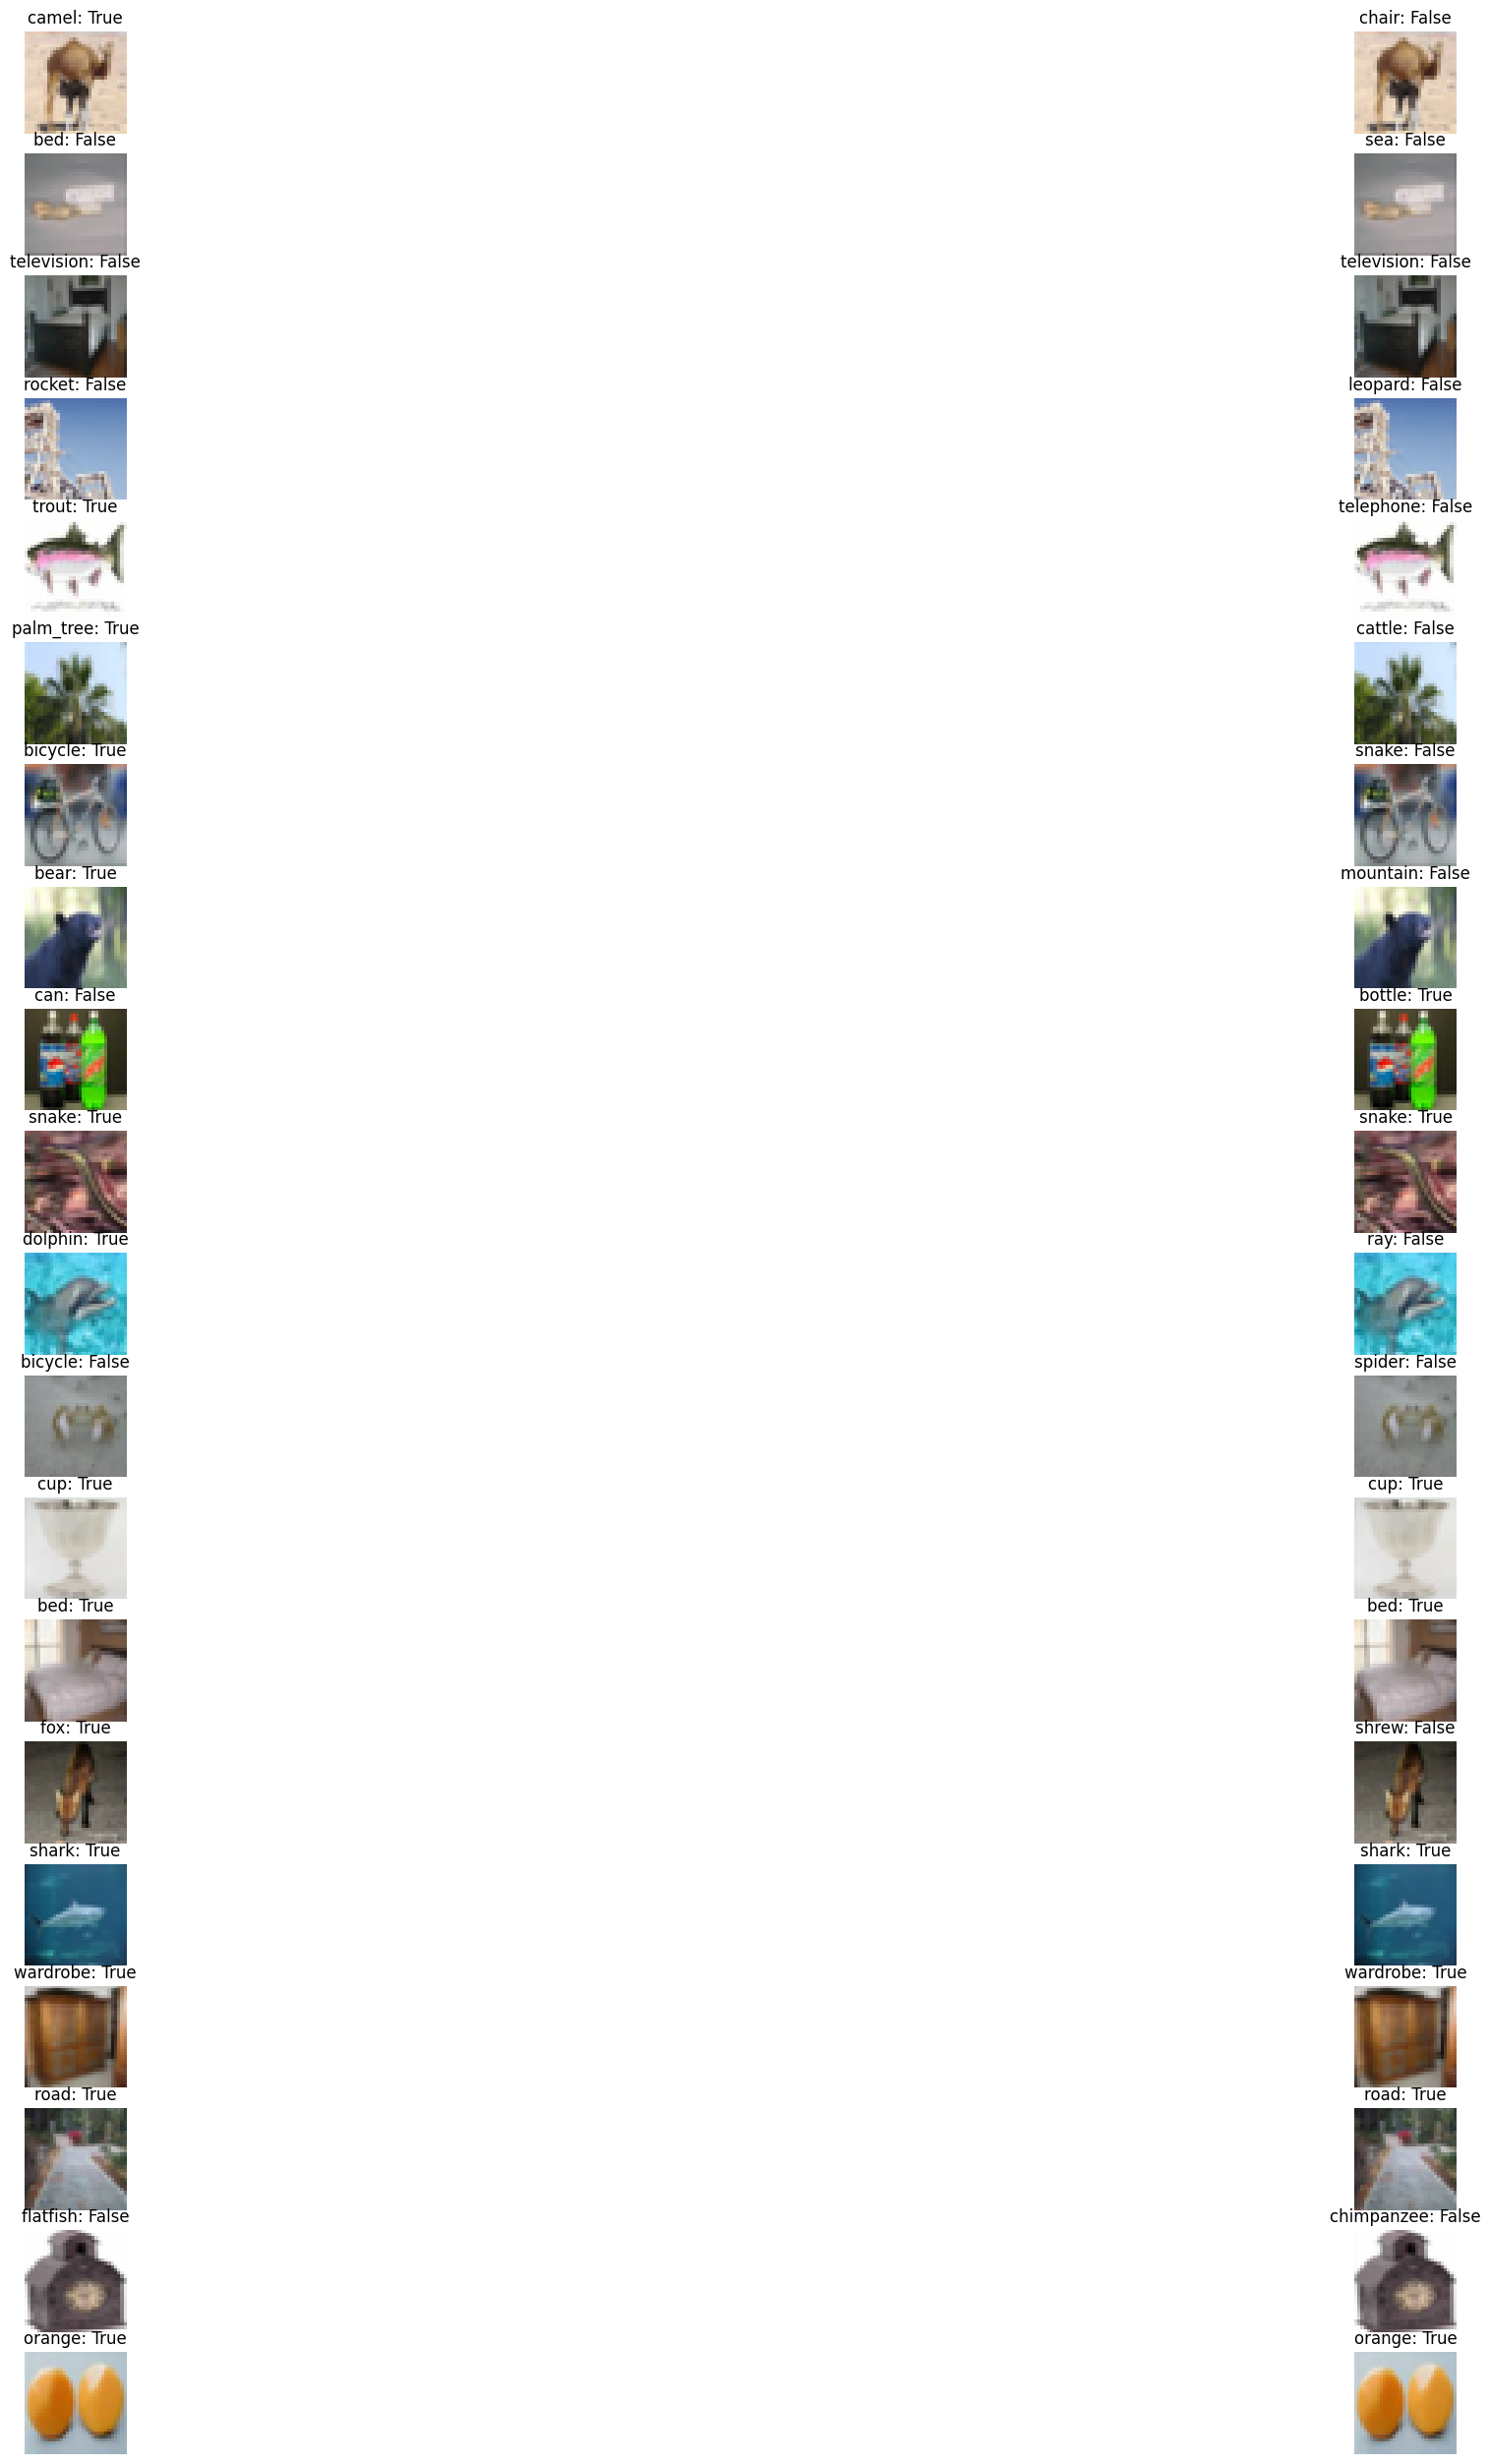

In [22]:
# результаты распознаваний (слева - самописная CNN, справа - дообученная ResNet50)
if use_cuda:
    images, labels = images.cuda(), labels.cuda()

outputs_my = model_my(images)
_, preds_my = torch.max(outputs_my.data, 1)
preds_my = preds_my.cpu().numpy() if use_cuda else preds_my.numpy()

outputs = model(images)
_, preds = torch.max(outputs.data, 1)
preds = preds.cpu().numpy() if use_cuda else preds.numpy()

fig, ax = plt.subplots(nrows=num, ncols=2, figsize=(32, 32))
for i in range(num):
    imshow(ax[i][0], images[i], '{}: {}'.format(classes[preds_my[i]], preds_my[i] == labels[i]))
    imshow(ax[i][1], images[i], '{}: {}'.format(classes[preds[i]], preds[i] == labels[i]))